In [1]:
!pip install pymysql
!pip install kmodes

     |████████████████████████████████| 51kB 1.7MB/s 


# Auto Insurance

This data set contains a total of 24 features divided into Customer Background, Insurance History, and Marketing.

1. Customer Background
  * Customer                        
  * State                            
  * Customer_Lifetime_Value          
  * Response                         
  * Coverage                         
  * Education                        
  * Effective_To_Date                
  * EmploymentStatus                 
  * Gender                           
  * Income                           
  * Location_Code                    
  * Marital_Status 

2. Insurance History

  * Monthly_Premium_Auto             
  * Months_Since_Last_Claim          
  * Months_Since_Policy_Inception    
  * Number_of_Open_Complaints        
  * Number_of_Policies               
  * Policy_Type                      
  * Policy                           
  * Renew_Offer_Type 
  * Total_Claim_Amount               
  * Vehicle_Class                    
  * Vehicle_Size

3. Marketing
  * Channel


The focus of this exercise is on customer segmentation.

In [0]:
import pandas            as pd
import scipy.stats
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import seaborn           as sns
import matplotlib.ticker as ticker
import pymysql

from   matplotlib.ticker import StrMethodFormatter
from   matplotlib.ticker import FuncFormatter

plt.rcParams['figure.facecolor'] = 'w'
sns.set()
#current_palette = sns.color_palette("cubehelix")
#current_palette = sns.color_palette("Paired")
current_palette = sns.color_palette("deep", 10)
sns.set_palette(current_palette)

# Specify the custom font to use
#plt.rcParams['font.sans-serif'] = 'Tahoma'

plt.rcParams["axes.labelweight"] = "bold"

# Save path for whatever needs to be output
save_path = '/content/gdrive/My Drive/Colab Notebooks/1000ML/Unit3_Clustering/Projects/Car_insurance/Slides/'

# Import libraries

In [0]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose         import ColumnTransformer
from sklearn.metrics         import classification_report, silhouette_score

from sklearn.linear_model    import LogisticRegression
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.cluster         import KMeans

from sklearn.decomposition   import PCA
from kmodes.kprototypes      import KPrototypes


In [4]:

from google.colab import drive

drive.mount('/content/gdrive/', force_remount = False)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
# Set directory path
file_path = '/content/gdrive/My Drive/Colab Notebooks/1000ML/Unit3_Clustering/Projects/Car_insurance/Car_insurance.csv'

# Import data set
df = pd.read_csv(file_path, sep=',', parse_dates=['Effective_To_Date'])

# Data Exploration

In [7]:
df.head()

,Customer,State,Customer_Lifetime_Value,Response,Coverage,Education,Effective_To_Date,EmploymentStatus,Gender,Income,Location_Code,Marital_Status,Monthly_Premium_Auto,Months_Since_Last_Claim,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Policy_Type,Policy,Renew_Offer_Type,Sales_Channel,Total_Claim_Amount,Vehicle_Class,Vehicle_Size
0,BU79786,Washington,2764,No,Basic,Bachelor,2011-02-24,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6980,No,Extended,Bachelor,2011-01-31,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887,No,Premium,Bachelor,2011-02-19,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7646,No,Basic,Bachelor,2011-01-20,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2814,No,Basic,Bachelor,2002-03-11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [8]:
(df['Customer'].value_counts() > 1).sum()

0

**OBSERVATIONS**: It looks like the customer id is all unique. These are all unique customers.

Look at the descriptive stats of numerical variables.

In [9]:
df.describe()

,Customer_Lifetime_Value,Income,Monthly_Premium_Auto,Months_Since_Last_Claim,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Total_Claim_Amount
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.945697,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794
std,6870.968043,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092
min,1898.000000,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,3994.250000,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244
50%,5780.000000,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434
75%,8962.250000,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839
max,83325.000000,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


Check if there are any null entries.

In [10]:
df.isnull().sum()

Customer                         0
State                            0
Customer_Lifetime_Value          0
Response                         0
Coverage                         0
Education                        0
Effective_To_Date                0
EmploymentStatus                 0
Gender                           0
Income                           0
Location_Code                    0
Marital_Status                   0
Monthly_Premium_Auto             0
Months_Since_Last_Claim          0
Months_Since_Policy_Inception    0
Number_of_Open_Complaints        0
Number_of_Policies               0
Policy_Type                      0
Policy                           0
Renew_Offer_Type                 0
Sales_Channel                    0
Total_Claim_Amount               0
Vehicle_Class                    0
Vehicle_Size                     0
dtype: int64

Look at distributions for a few features.

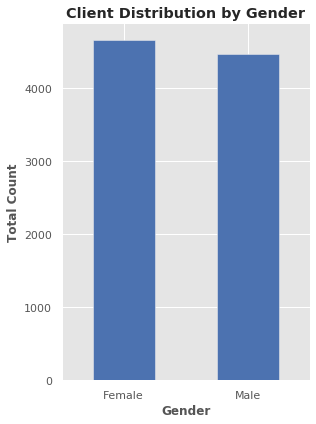

In [11]:
# Gender
plt.style.use('ggplot')
(df['Gender'].value_counts()).plot(kind = 'bar', rot = 0, color ='b', figsize=(4.5,6))

plt.xticks(ticks=[0,1],labels=['Female', 'Male'])
plt.title('Client Distribution by Gender',{'fontweight':'bold'})
plt.xlabel('Gender')
plt.ylabel('Total Count')
plt.tight_layout()
plt.savefig(save_path + 'gender_dist.png',dpi=1200, format='png',)

**OBSERVATIONS**: Gender is pretty evenly distributed.

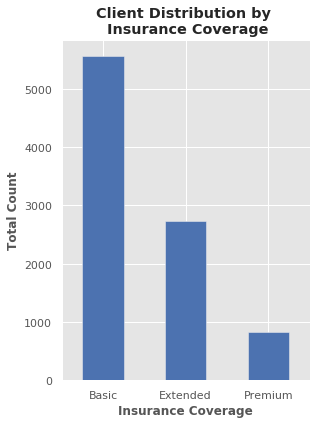

In [12]:
# Insurance coverage
plt.style.use('ggplot')
(df['Coverage'].value_counts()).plot(kind = 'bar', rot=0, color = 'b', figsize=(4.5,6))
plt.title('Client Distribution by \n Insurance Coverage',{'fontweight':'bold'})
plt.xlabel('Insurance Coverage')
plt.ylabel('Total Count')
plt.tight_layout()
plt.savefig(save_path + 'coverage_dist.png',dpi=1200, format='png',)

**OBSERVATIONS**: The Basic coverage is the most popular choice among customers.

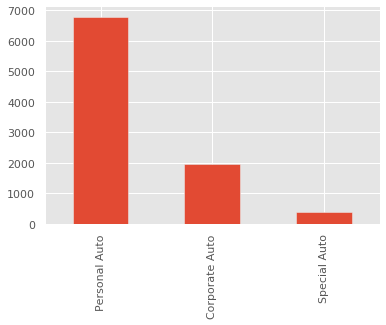

In [13]:
# Policy Type
(df['Policy_Type'].value_counts()).plot(kind = 'bar')

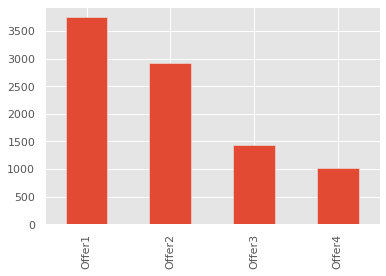

In [14]:
# Renew Offer Type
(df['Renew_Offer_Type'].value_counts()).plot(kind = 'bar')

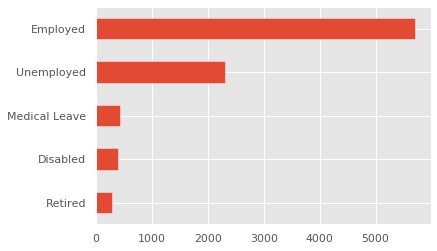

In [15]:
# Employment Status
(df['EmploymentStatus'].value_counts().sort_values()).plot(kind = 'barh')

**OBSERVATIONS**: Majority of customers are employed.

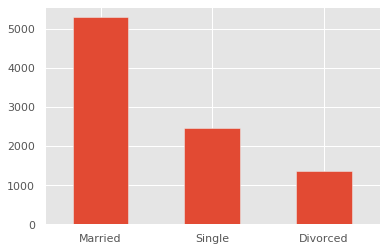

In [16]:
(df['Marital_Status'].value_counts()).plot(kind = 'bar', rot = 0)

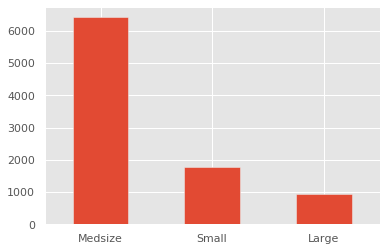

In [17]:
(df['Vehicle_Size'].value_counts()).plot(kind = 'bar', rot = 0)

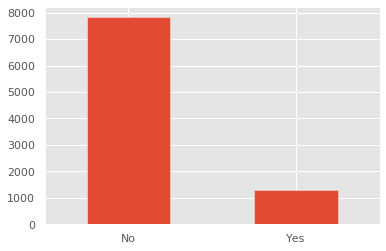

In [18]:
(df['Response'].value_counts()).plot(kind = 'bar', rot = 0)

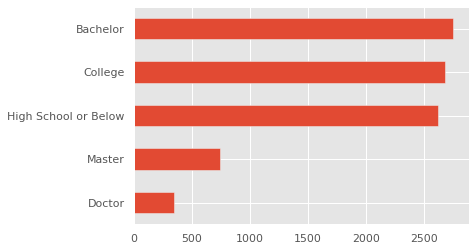

In [19]:
(df['Education'].value_counts().sort_values()).plot(kind = 'barh')

In [20]:
df['State'].value_counts()

California    3150
Oregon        2601
Arizona       1703
Nevada         882
Washington     798
Name: State, dtype: int64

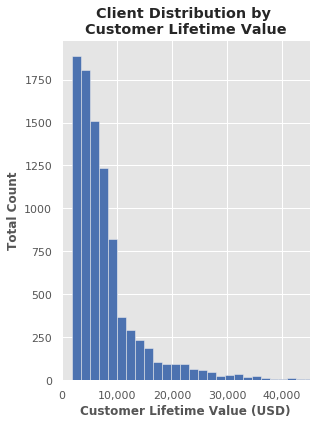

In [21]:
# Customer Lifetime vlaue
plt.figure (figsize =(4.5,6))
plt.style.use('ggplot')
sns.distplot(df['Customer_Lifetime_Value'], kde=False,color = 'b', hist_kws={'alpha':1})
plt.xlim(0,45000)
plt.xlabel('Customer Lifetime Value (USD)')
plt.ylabel('Total Count')
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) 
#plt.gca().ticklabel_format(axis='x', style='plain', useOffset=False)
plt.title('Client Distribution by \nCustomer Lifetime Value',{'fontweight':'bold'})
plt.tight_layout()
plt.savefig(save_path + 'clv_dist.png',dpi=1200, format='png',)

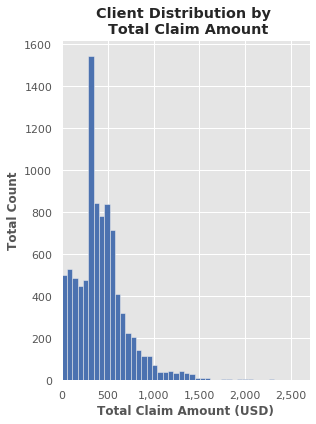

In [22]:
# Total Claim Amount
plt.figure (figsize =(4.5,6))
plt.style.use('ggplot')
sns.distplot(df['Total_Claim_Amount'], kde=False,color = 'b', hist_kws={'alpha':1})
plt.xlim(0,2700)
plt.xlabel('Total Claim Amount (USD)')
plt.ylabel('Total Count')
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) 
#plt.gca().ticklabel_format(axis='x', style='plain', useOffset=False)
plt.title('Client Distribution by \n Total Claim Amount',{'fontweight':'bold'})
plt.tight_layout()
plt.savefig(save_path + 'claim_dist.png',dpi=1200, format='png',)

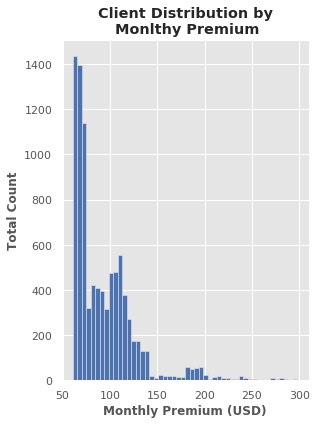

In [23]:
# Monthly Premium
plt.figure (figsize =(4.5,6))
plt.style.use('ggplot')
sns.distplot(df['Monthly_Premium_Auto'], kde=False,color = 'b', hist_kws={'alpha':1})
#plt.xlim(0,50000)
plt.xlabel('Monthly Premium (USD)')
plt.ylabel('Total Count')
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) 
#plt.gca().ticklabel_format(axis='x', style='plain', useOffset=False)
plt.title('Client Distribution by\n Monlthy Premium',{'fontweight':'bold'})
plt.tight_layout()
plt.savefig(save_path + 'premium_dist.png',dpi=1200, format='png',)

In [24]:
df.groupby(['Gender'])['Monthly_Premium_Auto'].mean()

Gender
F    93.087162
M    93.356792
Name: Monthly_Premium_Auto, dtype: float64

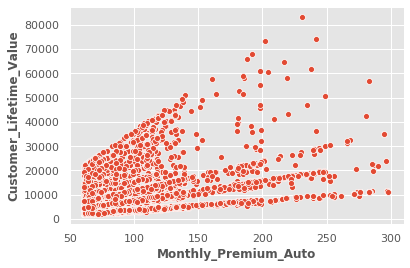

In [26]:
sns.scatterplot(x=df['Monthly_Premium_Auto'], y=df['Customer_Lifetime_Value'])
plt.show()

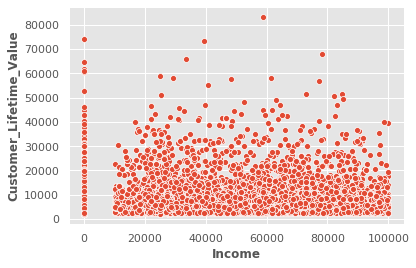

In [27]:
sns.scatterplot(x=df['Income'], y=df['Customer_Lifetime_Value'])
plt.show()

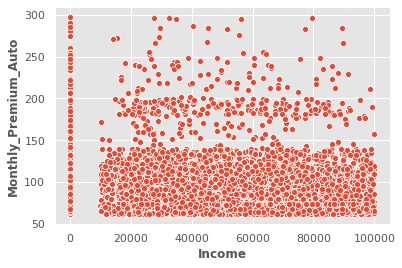

In [28]:
sns.scatterplot(x=df['Income'], y=df['Monthly_Premium_Auto'])
plt.show()

**NOTES**: For kNN, let us focus on Income, CLV, Monthly Premium, and Total Claim Amount. 

#$k$-Means - Numerical features

In [0]:
input_var = [
             'Income',
             'Customer_Lifetime_Value',
             'Monthly_Premium_Auto',
             'Total_Claim_Amount'
]


In [0]:
# Set variables
#X = df.drop(columns=['Coverage'])
df_sample = df.sample(frac=0.5, random_state = 42)
df_sample.reset_index(drop = True, inplace = True)
X = df_sample[input_var]

In [0]:

# Set transformer
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)

Should also do PCA to see how well the clusters are formed.

In [32]:
# PCA 
pca = PCA(n_components=2, random_state=42)

# Fit PCA
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
X_scaled_pca = pca.transform(X_scaled)

Finding the optimal number of clusters via the Elbow Method.

In [0]:
# k-Means
#Set K-Means with PCA
k_values = range(1,10)

#Make a list of all the models in a list
kmeans_pca_list = [KMeans(n_clusters= k, random_state = 42, n_jobs = -1).fit(X_scaled_pca) 
                  for k in k_values]

In [0]:
kmeans_pca_inertia = [model.inertia_ for model in kmeans_pca_list]

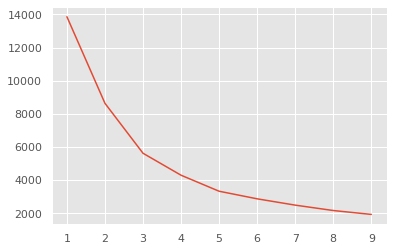

In [36]:
plt.plot(k_values, kmeans_pca_inertia)

**OBSERVATIONS**: From the elbow method, it looks like `k=3` is the optimal choice for kNN.

In [0]:
kmeans_pca = KMeans(n_clusters=4, random_state = 42, n_jobs = -1)

In [38]:
kmeans_pca.fit(X_scaled_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [39]:
kmeans_pca.cluster_centers_

array([[-0.53417147, -0.84631912],
       [-0.78542034,  0.87553209],
       [ 3.74725006,  1.06863698],
       [ 1.07634172, -0.45144757]])

Plot with PCA variables.

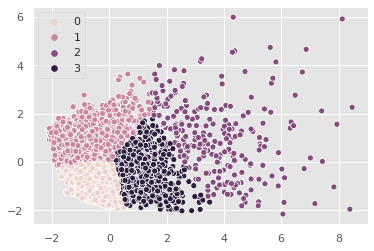

In [40]:
sns.scatterplot(x=X_scaled_pca[:,0], y=X_scaled_pca[:,1], hue=kmeans_pca.labels_)
plt.show()

**OBSERVATIONS**: From PCA, it shows that the features we selected yields 3 very distinct clusters. 

In [41]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
kmeans.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [42]:
kmeans_df = X
kmeans_df['label'] = kmeans.labels_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Plot with regular variables.

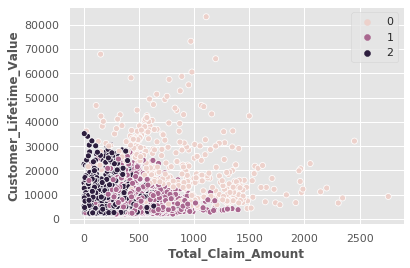

In [43]:
sns.scatterplot(x=X.iloc[:,3], y=X.iloc[:,1], hue=kmeans.labels_)
plt.show()

In [44]:
kmeans_df.head()

,Income,Customer_Lifetime_Value,Monthly_Premium_Auto,Total_Claim_Amount,label
0,74585,4223,106,218.598065,2
1,23218,5514,71,447.793440,1
2,94903,3808,94,451.200000,2
3,77153,7915,99,355.641958,2
4,23769,7932,69,470.097411,1


Perform some aggregations to further under the differences between clusters.

In [45]:
kmeans_df.groupby(['label']).agg({'Customer_Lifetime_Value': ['count', 'mean', 'std'],
                              #    'Income': ['count', 'mean', 'std'],
                                  'Monthly_Premium_Auto':['count', 'mean', 'std'],
                              #     'Months_Since_Last_Claim':['count', 'mean', 'std'],
                              #    'Number_of_Open_Complaints':['count', 'mean', 'std'],
                                   'Total_Claim_Amount':['count', 'mean', 'std'],
                                  })

Customer_Lifetime_Value                ... Total_Claim_Amount            
                        count          mean  ...               mean         std
label                                        ...                               
0                         456  20326.723684  ...         896.192447  421.765477
1                        2134   6481.414714  ...         481.268340  199.135001
2                        1977   7020.246333  ...         267.889982  164.528490

[3 rows x 9 columns]

Label 0: 
  * Lowest avg. CLV.

Label 1:
  * Lowest Monthly Premium Auto
  * Lowest Total Claim Amount.

Label 2:
  * Highest avg. CLV ($20000).
  * Highest avg. Total Claim Amount.

#$k$-prototypes - Numerical and Category features

In [0]:
input_var = [
             #'Income',
             'Customer_Lifetime_Value',
             'Monthly_Premium_Auto',
             'Total_Claim_Amount',
             #'Number_of_Policies',
             #'Number_of_Open_Complaints',
             #'Months_Since_Last_Claim',
             #'Months_Since_Policy_Inception',

             #'Location_Code',
             'State',
             'Gender',
             'Education',
             #'EmploymentStatus',
             #'Marital_Status',
             'Vehicle_Class',
            # 'Policy_Type',
             #'Renew_Offer_Type',
             'Sales_Channel',
             'Response',
             'Coverage',
]

num_var_temp = [
              #'Income',
              'Customer_Lifetime_Value',
             'Monthly_Premium_Auto',
             'Total_Claim_Amount',
             #'Number_of_Policies',
             #'Number_of_Open_Complaints',
             #'Months_Since_Last_Claim'
             #'Months_Since_Policy_Inception'
]

cat_var_temp = [
             #'Location_Code',
             'State',
             'Gender',
             'Education',
             #'EmploymentStatus',
             #'Marital_Status',
             'Vehicle_Class',
             #'Policy_Type',
             #'Renew_Offer_Type',
             'Sales_Channel',
             'Response',
             'Coverage',
]


**NOTES**: Various attributes were tested and the ones that are commented out did not yield any interesting/useful segments.

In [0]:
# Set variables

df_sample = df.sample(frac=1, random_state = 42)
df_sample.reset_index(drop = True, inplace = True)
X = df_sample[input_var]


In [0]:
# Column transformer

# Set transformer
col_transformer = ColumnTransformer(transformers = 
                                    [('scaler', StandardScaler(), num_var_temp)],
                                    remainder = 'passthrough', 
                                    verbose = True)

In [143]:
X_scaled = col_transformer.fit_transform(X)

[ColumnTransformer] ........ (1 of 2) Processing scaler, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


In [0]:
cat_var_index = [X.columns.get_loc(c) for c in cat_var_temp if c in X]

In [0]:
#Set K-Means with PCA
k_values = range(1,8)

#Make a list of all the models in a list

kproto_list = [KPrototypes(n_clusters= k, gamma = 0.5, random_state = 42, n_jobs = -1).fit(X_scaled, 
                                                                              categorical = cat_var_index
                                                                              ) 
                  for k in k_values]

In [0]:
kproto_cost = [model.cost_ for model in kproto_list]

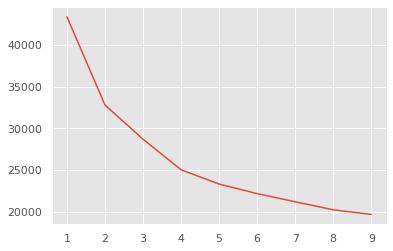

In [53]:
plt.plot(k_values, kproto_cost)

**OBSERVATIONS**: By the elbow method, we use 4 Clusters.

In [0]:
kproto = KPrototypes(n_clusters=4, gamma = 0.5, random_state = 42, n_jobs = -1)

In [146]:
kproto.fit(X_scaled, categorical = cat_var_index)

KPrototypes(cat_dissim=<function matching_dissim at 0x7f1786f0fe18>, gamma=0.5,
            init='Huang', max_iter=100, n_clusters=4, n_init=10, n_jobs=-1,
            num_dissim=<function euclidean_dissim at 0x7f178634f0d0>,
            random_state=42, verbose=0)

In [147]:
# Look at the centroids
kproto.cluster_centroids_

[array([[-0.39254818, -0.54002373, -0.50061965],
        [ 2.63793165,  0.09328298, -0.04539748],
        [-0.02824182,  0.52976257,  0.56506274],
        [ 1.09997838,  3.21049362,  2.67511256]]),
 array([['California', 'F', 'Bachelor', 'Four-Door Car', 'Agent', 'No',
         'Basic'],
        ['California', 'F', 'High School or Below', 'Four-Door Car',
         'Agent', 'No', 'Basic'],
        ['California', 'M', 'High School or Below', 'SUV', 'Agent', 'No',
         'Extended'],
        ['California', 'M', 'High School or Below', 'Luxury SUV', 'Agent',
         'No', 'Basic']], dtype='<U20')]

In [148]:
kproto_df = X
kproto_df['label'] = kproto.labels_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [149]:
kproto_df.head()

,Customer_Lifetime_Value,Monthly_Premium_Auto,Total_Claim_Amount,State,Gender,Education,Vehicle_Class,Sales_Channel,Response,Coverage,label
0,4223,106,218.598065,California,M,High School or Below,SUV,Agent,No,Basic,0
1,5514,71,447.793440,Oregon,F,High School or Below,Two-Door Car,Agent,No,Basic,0
2,3808,94,451.200000,Oregon,F,College,Two-Door Car,Agent,Yes,Extended,0
3,7915,99,355.641958,California,F,College,Four-Door Car,Branch,No,Extended,0
4,7932,69,470.097411,Washington,F,High School or Below,Four-Door Car,Branch,No,Basic,0


In [150]:
kproto_df.groupby(['label']).agg({'Customer_Lifetime_Value': ['count','min','max', 'mean', 'std'],
                                  'Monthly_Premium_Auto':['count','min','max','mean', 'std'],
                                   'Total_Claim_Amount':['count','min','max', 'mean', 'std'],
                                  })

Customer_Lifetime_Value         ... Total_Claim_Amount            
                        count    min  ...               mean         std
label                                 ...                               
0                        5277   1898  ...         288.666700  149.007915
1                         646  15228  ...         420.901544  241.230576
2                        2805   2053  ...         598.230586  206.260472
3                         406   4503  ...        1211.166698  398.518999

[4 rows x 15 columns]

**OBSERVATIONS**: Similar clusters are seen from kMeans but with an addition cluster (Label 3). 

In the following, we examine the characteristics grouped by the different clusters according to the kprototype model.

In [97]:
kproto_df.groupby(['label'])['Coverage'].agg(pd.Series.mode)

label
0       Basic
1       Basic
2       Basic
3    Extended
Name: Coverage, dtype: object

In [61]:
kproto_df.groupby(['label'])['Coverage'].value_counts()

label  Coverage
0      Basic       3979
       Extended    1175
       Premium      123
1      Basic        388
       Extended     198
       Premium       60
2      Extended    1244
       Basic       1055
       Premium      506
3      Basic        146
       Premium      135
       Extended     125
Name: Coverage, dtype: int64

In [62]:
kproto_df.groupby(['label'])['Vehicle_Class'].value_counts()

label  Vehicle_Class
0      Four-Door Car    3611
       Two-Door Car     1378
       SUV               218
       Sports Car         70
1      Four-Door Car     282
       SUV               171
       Two-Door Car      118
       Sports Car         58
       Luxury SUV          9
       Luxury Car          8
2      SUV              1323
       Four-Door Car     728
       Two-Door Car      390
       Sports Car        334
       Luxury SUV         17
       Luxury Car         13
3      Luxury SUV        158
       Luxury Car        142
       SUV                84
       Sports Car         22
Name: Vehicle_Class, dtype: int64

In [63]:
kproto_df.groupby(['label'])['Gender'].value_counts()

label  Gender
0      F         2896
       M         2381
1      F          369
       M          277
2      M         1595
       F         1210
3      M          223
       F          183
Name: Gender, dtype: int64

In [64]:
kproto_df.groupby(['label'])['State'].value_counts()

label  State     
0      California    1791
       Oregon        1507
       Arizona       1022
       Nevada         488
       Washington     469
1      California     220
       Oregon         178
       Arizona        116
       Nevada          67
       Washington      65
2      California    1004
       Oregon         786
       Arizona        492
       Nevada         289
       Washington     234
3      California     135
       Oregon         130
       Arizona         73
       Nevada          38
       Washington      30
Name: State, dtype: int64

In [0]:
#kproto_df.groupby(['label', 'State'])['Location_Code'].value_counts()

In [66]:
kproto_df.groupby(['label'])['Education'].value_counts()

label  Education           
0      Bachelor                1752
       College                 1580
       High School or Below    1260
       Master                   460
       Doctor                   225
1      High School or Below     210
       Bachelor                 191
       College                  172
       Master                    52
       Doctor                    21
2      High School or Below    1019
       College                  822
       Bachelor                 682
       Master                   193
       Doctor                    89
3      High School or Below     133
       Bachelor                 123
       College                  107
       Master                    36
       Doctor                     7
Name: Education, dtype: int64

In [67]:
kproto_df.groupby(['label'])['Sales_Channel'].value_counts()

label  Sales_Channel
0      Agent            2017
       Branch           1454
       Call Center      1011
       Web               795
1      Agent             237
       Branch            197
       Call Center       123
       Web                89
2      Agent            1060
       Branch            808
       Call Center       562
       Web               375
3      Agent             163
       Branch            108
       Call Center        69
       Web                66
Name: Sales_Channel, dtype: int64